In [2]:
from collections import Counter
from functools import partial
from multiprocessing import Pool
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm.notebook as tqdm

from datasets import load_dataset
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, BertTokenizer

In [ ]:
data_dir = Path("datasets/imdb")
data_dir.mkdir(parents=True, exist_ok=True)
dataset = load_dataset("imdb", cache_dir=data_dir)

In [ ]:
# Easy way to split a dataset into train and validation sets

# train_df = dataset["train"].to_pandas()
# train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=0)

# A more careful way to split a dataset into train and validation sets considering the label distribution

full_df = dataset["train"].to_pandas()
np.random.seed(0)
positive_df = full_df[full_df["label"] == 1].sample(frac=1) # shuffle
negative_df = full_df[full_df["label"] == 0].sample(frac=1) # shuffle
train_df = pd.concat([positive_df[:int(len(positive_df) * 0.8)], negative_df[:int(len(negative_df) * 0.8)]])
valid_df = pd.concat([positive_df[int(len(positive_df) * 0.8):], negative_df[int(len(negative_df) * 0.8):]])

test_df = dataset["test"].to_pandas()

print("Training set size:", len(train_df))
print("Validation set size:", len(valid_df))
print("Test set size:", len(test_df))

In [ ]:
nlp = spacy.load('en_core_web_sm')

use_lemma = True
use_lower = True
remove_punct = True


def process(text, remove_punct=True, use_lemma=True, use_lower=True):
    words, processed_words = [], []
    for word in nlp(text):
        words.append(word.text)
        if word.is_space or (remove_punct and word.is_punct):
            continue
        processed_words.append(word.lemma_ if use_lemma else word.text)

    if use_lower:
        processed_words = [word.lower() for word in words]
    
    return " ".join(words), " ".join(processed_words)


from tqdm import tqdm
tqdm.pandas() 
train_df["processed_text"] = train_df["text"].progress_apply(process)
valid_df["processed_text"] = valid_df["text"].progress_apply(process)
test_df["processed_text"] = test_df["text"].progress_apply(process)
train_df["processed_text_length"] = train_df["processed_text"].apply(lambda x: len(x.split()))
valid_df["processed_text_length"] = valid_df["processed_text"].apply(lambda x: len(x.split()))
test_df["processed_text_length"] = test_df["processed_text"].apply(lambda x: len(x.split()))
import tqdm.notebook as tqdm

In [ ]:
# Note: you'll likely have to run the multiprocessing code as a separate script file

remove_punct = True
use_lemma = True
use_lower = True


def worker_initializer():
    global nlp
    nlp = spacy.load('en_core_web_sm')

    
def process(text, remove_punct=True, use_lemma=True, use_lower=True):
    words, processed_words = [], []
    for word in nlp(text):
        words.append(word.text)
        if word.is_space or (remove_punct and word.is_punct):
            continue
        processed_words.append(word.lemma_ if use_lemma else word.text)

    if use_lower:
        processed_words = [word.lower() for word in words]
    
    return " ".join(words), " ".join(processed_words)

process_func = partial(process, remove_punct=remove_punct, use_lemma=use_lemma, use_lower=use_lower) 

with Pool(
    processes=8,
    initializer=worker_initializer,
) as pool:
    train_df["processed_text"] = list(tqdm.tqdm(pool.imap(process, train_df["text"], chunksize=1), total=len(train_df)))  
    valid_df["processed_text"] = list(tqdm.tqdm(pool.imap(process, valid_df["text"], chunksize=1), total=len(valid_df)))
    test_df["processed_text"] = list(tqdm.tqdm(pool.imap(process, test_df["text"], chunksize=1), total=len(test_df)))
    
train_df["processed_text_length"] = train_df["processed_text"].apply(lambda x: len(x.split()))
valid_df["processed_text_length"] = valid_df["processed_text"].apply(lambda x: len(x.split()))
test_df["processed_text_length"] = test_df["processed_text"].apply(lambda x: len(x.split()))

In [ ]:
train_df.to_csv("datasets/imdb/train.csv", index=False)
valid_df.to_csv("datasets/imdb/valid.csv", index=False)
test_df.to_csv("datasets/imdb/test.csv", index=False)

In [3]:
train_df = pd.read_csv("datasets/imdb/train.csv")
valid_df = pd.read_csv("datasets/imdb/valid.csv")
test_df = pd.read_csv("datasets/imdb/test.csv")

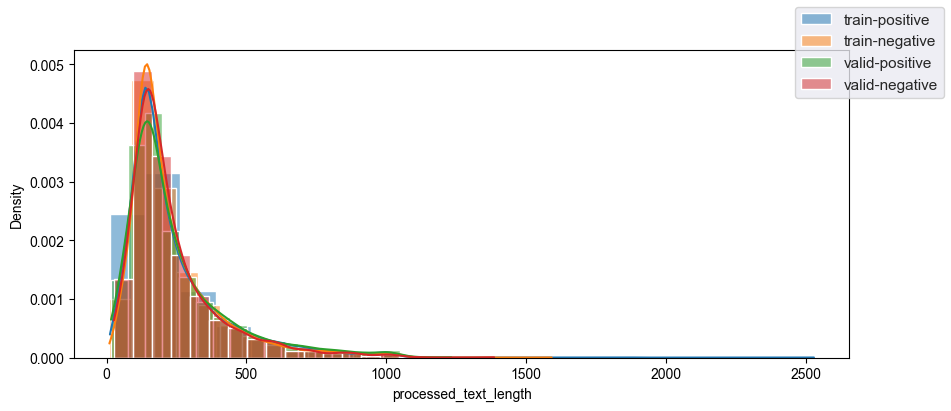

In [4]:
train_df["processed_text_length"] = train_df["processed_text"].apply(lambda x: len(x.split()))
valid_df["processed_text_length"] = valid_df["processed_text"].apply(lambda x: len(x.split()))
test_df["processed_text_length"] = test_df["processed_text"].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(figsize=(10, 4))
sns.set_theme()
sns.histplot(train_df[train_df["label"] == 1]["processed_text_length"], label="train-positive", ax=ax, stat="density", kde=True, bins=20)
sns.histplot(train_df[train_df["label"] == 0]["processed_text_length"], label="train-negative", ax=ax, stat="density", kde=True, bins=20)
sns.histplot(valid_df[valid_df["label"] == 1]["processed_text_length"], label="valid-positive", ax=ax, stat="density", kde=True, bins=20)
sns.histplot(valid_df[valid_df["label"] == 0]["processed_text_length"], label="valid-negative", ax=ax, stat="density", kde=True, bins=20)
fig.legend()

In [ ]:
# Vader Setiment Intesity Analyzer
# Valid acc: 0.6914, Test acc: 0.6958
import nltk
nltk.download("vader_lexicon")

analyzer = SentimentIntensityAnalyzer()

preds = []
for sentence in tqdm.tqdm(valid_df["processed_text"]):
    result = analyzer.polarity_scores(sentence)
    preds.append(1 if result["pos"] >= result["neg"] else 0)
preds = np.array(preds)

print("Valid accuracy:", (preds == valid_df["label"]).mean())

preds = []
for sentence in tqdm.tqdm(test_df["processed_text"]):
    result = analyzer.polarity_scores(sentence)
    preds.append(1 if result["pos"] >= result["neg"] else 0)
preds = np.array(preds)

print("Test accuracy:", (preds == test_df["label"]).mean())

In [ ]:
# Logistic regression based on TruncatedSVD of TF-IDF of the processed texts
# Valid acc: 0.8698, Test acc: 0.8606
np.random.seed(0)

model = Pipeline(
    [
        ("vectorizer", CountVectorizer(token_pattern="\S+", min_df=50, max_df=0.8, stop_words='english')),
        ("tfidf", TfidfTransformer()),
        ("svd", TruncatedSVD(n_components=2048)),
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(C=0.001))
    ]
)

model.fit(train_df["processed_text"], train_df["label"])

print("Train accuracy:", (model.predict(train_df["processed_text"]) == train_df["label"]).mean())
print("Valid accuracy:", (model.predict(valid_df["processed_text"]) == valid_df["label"]).mean())

print("Test accuracy:", (model.predict(test_df["processed_text"]) == test_df["label"]).mean())

In [ ]:
# Create the GloVe embeddings matrix for NN model (optional); you'll have to download the GloVe embeddings from https://nlp.stanford.edu/projects/glove/
# Recommended reading: https://www.ruder.io/word-embeddings-1/
# Thought experiment: why would we like to NOT use the pre-trained word embeddings? What are some of the advantages of training our own embeddings?

word_counter = Counter(
    [word for text in train_df["processed_text"] for word in text.split(' ')] +
    [word for text in valid_df["processed_text"] for word in text.split(' ')]
)

word2idx, idx2word = {"<UNK>": 0, "<PAD>": 1}, ["<UNK>", "<PAD>"]

covered = 0
for word, count in word_counter.most_common()[:19998]:
    word2idx[word] = len(idx2word)
    idx2word.append(word)
    covered += count
print(f"Word coverage: {covered / sum(word_counter.values()) * 100:.4f}%")

embeddings_matrix = np.random.uniform(-1, 1, (len(idx2word), 300)).astype(np.float32)
embeddings_matrix[1, :] = 0
with open("../datasets/glove/glove.6B.300d.txt") as file:
    for line in file:
        chunks = line.split(' ')
        word, embedding = chunks[0], np.array(chunks[1:], dtype=np.float32)
        if word in word2idx:
            embeddings_matrix[word2idx[word]] = embedding
            
embeddings = nn.Embedding.from_pretrained(torch.from_numpy(embeddings_matrix), padding_idx=1)

In [4]:
class CNNClassifier(nn.Module):
    def __init__(self, embeddings=None, vocab_size=None, embedding_dim=None):
        super(CNNClassifier, self).__init__()
        if embeddings is not None:
            self._embeddings = embeddings
        else:
            assert vocab_size is not None and embedding_dim is not None
            self._embeddings = nn.Embedding(vocab_size, embedding_dim)
        self._cnn_layers = nn.ModuleList([
            nn.Conv1d(in_channels=self._embeddings.embedding_dim, out_channels=100, kernel_size=3, padding="same"),
            nn.Conv1d(in_channels=self._embeddings.embedding_dim, out_channels=100, kernel_size=4, padding="same"),
            nn.Conv1d(in_channels=self._embeddings.embedding_dim, out_channels=100, kernel_size=5, padding="same"),
        ])
        self._avg_pooling = nn.AdaptiveAvgPool1d(1)
        self._max_pooling = nn.AdaptiveMaxPool1d(1)
        self._dropout = nn.Dropout(0.5)
        self._linear = nn.Linear(600, 1)
       
    def forward(self, x: torch.LongTensor) -> torch.Tensor:
        e = self._embeddings(x).permute(0, 2, 1)
        c = torch.cat([cnn(e) for cnn in self._cnn_layers], dim=1)
        c = self._dropout(F.relu(c))
        p = torch.cat([self._avg_pooling(c), self._max_pooling(c)], dim=1).squeeze(2)
        return torch.sigmoid(self._linear(p).squeeze())


class CNNLSTMClassifier(nn.Module):
    def __init__(self, embeddings=None, vocab_size=None, embedding_dim=None):
        super(CNNLSTMClassifier, self).__init__()
        if embeddings is not None:
            self._embeddings = embeddings
        else:
            assert vocab_size is not None and embedding_dim is not None
            self._embeddings = nn.Embedding(vocab_size, embedding_dim)
        self._cnn_layers = nn.ModuleList([
            nn.Conv1d(in_channels=self._embeddings.embedding_dim, out_channels=100, kernel_size=3, padding="same"),
            nn.Conv1d(in_channels=self._embeddings.embedding_dim, out_channels=100, kernel_size=4, padding="same"),
            nn.Conv1d(in_channels=self._embeddings.embedding_dim, out_channels=100, kernel_size=5, padding="same"),
        ])
        self._lstm = nn.LSTM(batch_first=True, input_size=600, hidden_size=300, bidirectional=True)
        self._avg_pool = nn.AvgPool1d(kernel_size=2)
        self._max_pool = nn.MaxPool1d(kernel_size=2)
        self._cnn_dropout = nn.Dropout(0.4)
        self._rnn_dropout = nn.Dropout(0.1)
        self._linear = nn.Linear(600, 1)
       
    def forward(self, x: torch.LongTensor, l: torch.LongTensor) -> torch.Tensor:
        e = self._embeddings(x).permute(0, 2, 1)
        c = F.relu(torch.cat([cnn(e) for cnn in self._cnn_layers], dim=1))
        c = self._cnn_dropout(c)
        c = torch.cat([self._avg_pool(c), self._max_pool(c)], dim=1).permute(0, 2, 1)
        c = pack_padded_sequence(c, l // 2, batch_first=True, enforce_sorted=False)
        _, (h, _) = self._lstm(c)
        return torch.sigmoid(self._linear(h.permute(1, 0, 2).reshape(x.shape[0], -1)).squeeze())

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, word2idx, texts, labels):
        self._word2idx = word2idx
        self._texts = texts
        self._labels = labels
        assert len(self._texts) == len(self._labels)
        
    def __len__(self):
        return len(self._texts)

    def __getitem__(self, index):
        text, label = self._texts[index], self._labels[index]
        tokens = torch.tensor(
            [self._word2idx.get(word, 0) for word in text.split(' ')],
            dtype=torch.long
        )
        return tokens, torch.tensor(label, dtype=torch.float)
    
    
def build_collate_fn(max_length=512):
    def collate_fn(batch):
        batch.sort(key=lambda x: len(x[0]), reverse=True)
        texts, labels = zip(*batch)
        texts = [text[:max_length] for text in texts]
        lengths = torch.LongTensor([len(text) for text in texts])
        texts = pad_sequence(texts, batch_first=True, padding_value=1)
        labels = torch.tensor(labels, dtype=torch.float)
        return texts, labels, lengths
    
    return collate_fn

In [ ]:
train_dataset = IMDBDataset(word2idx, texts=train_df['processed_text'], labels=train_df['label'])
valid_dataset = IMDBDataset(word2idx, texts=valid_df['processed_text'], labels=valid_df['label'])
test_dataset = IMDBDataset(word2idx, texts=test_df['processed_text'], labels=test_df['label'])
collate_fn = build_collate_fn(max_length=1024)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [ ]:
class Trainer:
    def __init__(self, num_epochs, train_dataloader, valid_dataloader):
        self._num_epochs = num_epochs
        self._train_dataloader = train_dataloader
        self._valid_dataloader = valid_dataloader
    
    def _run_batch(self, batch):
        raise NotImplementedError
    
    def _inference(self, batch):
        raise NotImplementedError
    
    def _load_model(self, path=None):
        raise NotImplementedError
        
    def _save_model(self):
        raise NotImplementedError
        
    def train_epoch(self):
        epoch_loss, count = 0.0, 0
        epoch_bar = tqdm.tqdm(self._train_dataloader, leave=False)
        
        for batch in epoch_bar:
            preds, batch_loss = self._run_batch(batch)
            epoch_loss = epoch_loss * count + batch_loss * preds.shape[0] 
            count += preds.shape[0]
            epoch_loss /= count
            epoch_bar.set_description(f"loss: {epoch_loss:.4f}")
        
        return epoch_loss
    
    def evaluate(self, dataloader=None):
        dataloader = self._valid_dataloader if dataloader is None else dataloader

        eval_loss, eval_hit, count = 0.0, 0, 0 
        for batch in tqdm.tqdm(dataloader, leave=False):
            preds, batch_loss = self._inference(batch)
            eval_loss = eval_loss * count + batch_loss * preds.shape[0]
            count += preds.shape[0]
            eval_loss /= count
            eval_hit += (preds.round() == batch[1]).sum().item()
            
        return eval_loss, eval_hit / count
           
    def train(self):
        best_acc = 0.0

        train_bar = tqdm.trange(self._num_epochs)
        for i in train_bar:            
            epoch_loss = self.train_epoch()
            train_bar.write(f"train loss for epoch {i}: {epoch_loss:.4f}")
            eval_loss, eval_acc = self.evaluate()
            train_bar.write(f"valid loss for epoch {i}: {eval_loss:.4f}")
            train_bar.write(f"valid acc for epoch {i}: {eval_acc:.4f}") 
            
            if eval_acc > best_acc:
                best_acc = eval_acc
                self._save_model()

In [ ]:
class CNNTrainer(Trainer):
    def __init__(
        self,
        network,
        optimizer,
        device,
        num_epochs,
        train_dataloader,
        valid_dataloader,
    ):
        super().__init__(num_epochs, train_dataloader, valid_dataloader)
        self._network = network
        self._optimizer = optimizer
        self._device = device
        
    def _run_batch(self, batch):
        self._optimizer.zero_grad()
        preds = self._network(batch[0].to(device=self._device))
        loss = F.binary_cross_entropy(preds, batch[1].to(device=self._device))
        loss.backward()
        self._optimizer.step()
        
        return preds.cpu(), loss.item()
    
    def _inference(self, batch):
        with torch.no_grad():
            preds = self._network(batch[0].to(device=self._device))
            loss = F.binary_cross_entropy(preds, batch[1].to(device=self._device))
            preds = preds.round()
            
        return preds.cpu(), loss.item()
    
    def _load_model(self, path=None):
        path = "cnn_model.ckpt" if path is None else path
        self._network.load_state_dict(torch.load(path))
    
    def _save_model(self):
        torch.save(self._network.state_dict(), "cnn_model.ckpt")

In [ ]:
class CNNLSTMTrainer(Trainer):
    def __init__(
        self,
        network,
        optimizer,
        device,
        num_epochs,
        train_dataloader,
        valid_dataloader,
    ):
        super().__init__(num_epochs, train_dataloader, valid_dataloader)
        self._network = network
        self._optimizer = optimizer
        self._device = device
        
    def _run_batch(self, batch):
        self._optimizer.zero_grad()
        preds = self._network(batch[0].to(device=self._device), batch[2])
        loss = F.binary_cross_entropy(preds, batch[1].to(device=self._device))
        loss.backward()
        self._optimizer.step()
        
        return preds.cpu(), loss.item()
    
    def _inference(self, batch):
        with torch.no_grad():
            preds = self._network(batch[0].to(device=self._device), batch[2])
            loss = F.binary_cross_entropy(preds, batch[1].to(device=self._device))
            preds = preds.round()
            
        return preds.cpu(), loss.item()

    def _load_model(self, path=None):
        path = "cnn_lstm_model.ckpt" if path is None else path
        self._network.load_state_dict(torch.load(path))
    
    def _save_model(self):
        torch.save(self._network.state_dict(), "cnn_lstm_model.ckpt")

In [ ]:
# Valid acc: 0.8844, Test acc: 0.8789

device = "cpu"
# network = CNNClassifier(embeddings=embeddings).to(device=device)
network = CNNClassifier(len(idx2word), 300).to(device=device)
optimizer = optim.Adam(network.parameters(), lr=0.001)
trainer = CNNTrainer(network, optimizer, device, 5, train_dataloader, valid_dataloader)
trainer.train()

trainer._load_model()
trainer.evaluate(test_dataloader)

In [ ]:
# Valid acc: 0.8902, Test acc: 0.8720

device = "cpu"
# network = CNNLSTMClassifier(embeddings=embeddings).to(device=device)
network = CNNLSTMClassifier(len(idx2word), 300).to(device=device)
optimizer = optim.Adam(network.parameters(), lr=0.001)
trainer = CNNLSTMTrainer(network, optimizer, device, 5, train_dataloader, valid_dataloader)
trainer.train()

trainer._load_model()
trainer.evaluate(test_dataloader)

In [ ]:
class IMDBBERTDataset(Dataset):
    def __init__(self, texts, labels):
        self._texts = texts
        self._labels = labels
        assert len(self._texts) == len(self._labels)
        
    def __len__(self):
        return len(self._texts)

    def __getitem__(self, index):
        return self._texts[index], torch.tensor(self._labels[index], dtype=torch.float)
    
    
def build_bert_collate_fn(tokenizer):
    def collate_fn(batch):
        texts, labels = zip(*batch)
        texts = list(texts)
        texts = tokenizer(texts, return_tensors='pt', padding=True, max_length=tokenizer.model_max_length, truncation=True)
        labels = torch.tensor(labels, dtype=torch.float)
        return texts, labels
    
    return collate_fn

In [ ]:
train_dataset = IMDBBERTDataset(texts=train_df['processed_text'], labels=train_df['label'])
valid_dataset = IMDBBERTDataset(texts=valid_df['processed_text'], labels=valid_df['label'])
test_dataset = IMDBBERTDataset(texts=test_df['processed_text'], labels=test_df['label'])
collate_fn = build_bert_collate_fn(tokenizer=BertTokenizer.from_pretrained("bert-base-uncased"))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [ ]:
class BERTTrainer(Trainer):
    def __init__(
        self,
        network,
        optimizer,
        device,
        num_epochs,
        train_dataloader,
        valid_dataloader,
    ):
        super().__init__(num_epochs, train_dataloader, valid_dataloader)
        self._network = network
        self._optimizer = optimizer
        self._device = device
        
    def _run_batch(self, batch):
        self._optimizer.zero_grad()
        preds = self._network(**batch[0].to(device=self._device)).logits.squeeze()
        loss = F.binary_cross_entropy_with_logits(preds, batch[1].to(device=self._device))
        loss.backward()
        self._optimizer.step()
        
        return preds, loss.item()
    
    def _inference(self, batch):
        with torch.no_grad():
            preds = self._network(**batch[0].to(device=self._device)).logits.squeeze()
            loss = F.binary_cross_entropy_with_logits(preds, batch[1].to(device=self._device))
            preds = (preds >= 0).to(dtype=torch.float32)
            
        return preds.cpu(), loss.item()
    
    def _load_model(self, path=None):
        path = "bert_model.ckpt" if path is None else path
        self._network.load_state_dict(torch.load(path))
    
    def _save_model(self):
        torch.save(self._network.state_dict(), "bert_model.ckpt")

In [ ]:
# Valid acc: 0.9308, Test acc: 0.9350
device = "cpu"
network = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1).to(device=device)
optimizer = optim.Adam(network.parameters(), lr=3e-5)
trainer = BERTTrainer(network, optimizer, device, 3, train_dataloader, valid_dataloader)
trainer.train()

trainer._load_model()
trainer.evaluate(test_dataloader)

In [ ]:
# A prototype of promping GPT-3.5/GPT-4 to do sentiment analysis (NOTE: this isn't fully run and debugged yet, be aware of your usage!)
import openai

openai.api_key = "YOUR_API_KEY_HERE"

np.random.seed(0)

positive = train_df[(train_df["label"] == 1) & (train_df["text_length"] > 100) & (train_df["text_length"] <= 1000)]
negative = train_df[(train_df["label"] == 0) & (train_df["text_length"] > 100) & (train_df["text_length"] <= 1000)]

positive_samples = "\n".join(positive.sample(2)["text"].values)
negative_samples = "\n".join(negative.sample(2)["text"].values)

template = """You're going to do a binary sentiment analysis task on movie reviews, where positive means that the review is positive regarding the movie, and vice versa. Here are some positive and negative samples.

Positive ones are listed as below:
{positive_samples}

Negative ones are listed as below:
{negative_samples}

Now, tell me the sentiment of the review below. Only give me the word \"positive\" or \"negative\". Here is the review:
{text}
"""


def evaluate(df):
    preds = []
    for text in tqdm.tqdm(df["text"]):
        message = template.format(positive_samples=positive_samples, negative_samples=negative_samples, text=text)
        pred = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "user", "content": message},
            ]
        )["choices"][0]["message"]["content"]

        preds.append(1 if "positive" in pred else 0)

    preds = np.array(preds)
    print(f"Accuracy: {np.mean(preds == df['label'].values)}")

In [ ]:
evaluate(valid_df)

In [ ]:
evaluate(test_df)